# Новый раздел

Подключение библиотек

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import losses, optimizers
from tensorflow.keras.utils import to_categorical

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

import shutil
import matplotlib.pyplot as plt
import numpy as np
import random
import os

## Задание 1. 

Постройте графики ошибок на обучающей и тестовой выборке в процессе обучения

Генерация данных

In [2]:
np.random.seed(42)
n = 1000
X, Y = make_classification(n_samples = n, n_features=2, n_redundant=0, n_informative=2, flip_y=0.2, class_sep=1)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

train_x, test_x = np.split(X, [800])
train_labels, test_labels = np.split(Y, [800])

Функция вывода графика сгенерированных данных

In [3]:
def plot_dataset(features, labels, W=None, b=None):
    plt.figure(figsize=(14, 10))
    plt.xlabel('$x_i[0]$ -- (feature 1)')
    plt.ylabel('$x_i[1]$ -- (feature 2)')
    colors = ['r' if l else 'b' for l in labels]
    plt.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    if W is not None:
        min_x = min(features[:,0])
        max_x = max(features[:,1])
        min_y = min(features[:,1])*(1-.1)
        max_y = max(features[:,1])*(1+.1)
        cx = np.array([min_x,max_x],dtype=np.float32)
        cy = (0.5-W[0]*cx-b)/W[1]
        plt.plot(cx, cy,'g')
        plt.ylim(min_y,max_y)
    plt.show()

Вывод графика сгенерированных точек

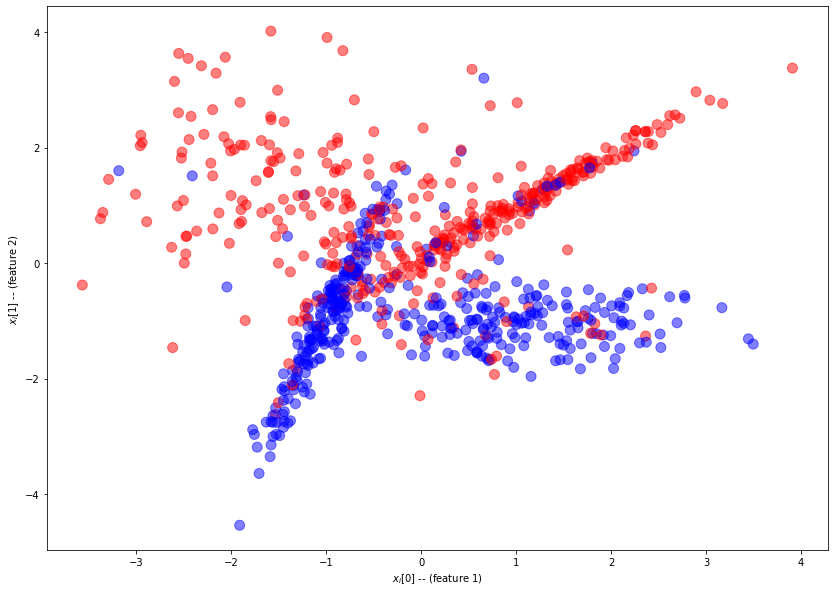

In [4]:
plot_dataset(train_x, train_labels)

In [5]:
W = tf.Variable(tf.random.normal(shape=(2, 1)))
b = tf.Variable(tf.zeros(shape=(1,), dtype=tf.float32))

learning_rate = 0.1

@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    z = tf.matmul(x, W) + b
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=z))
    dloss_dw, dloss_db = tape.gradient(loss, [W, b])
  W.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

Вывод графика сгенерированных точек вместе с линий проведенной через созданные ранее веса

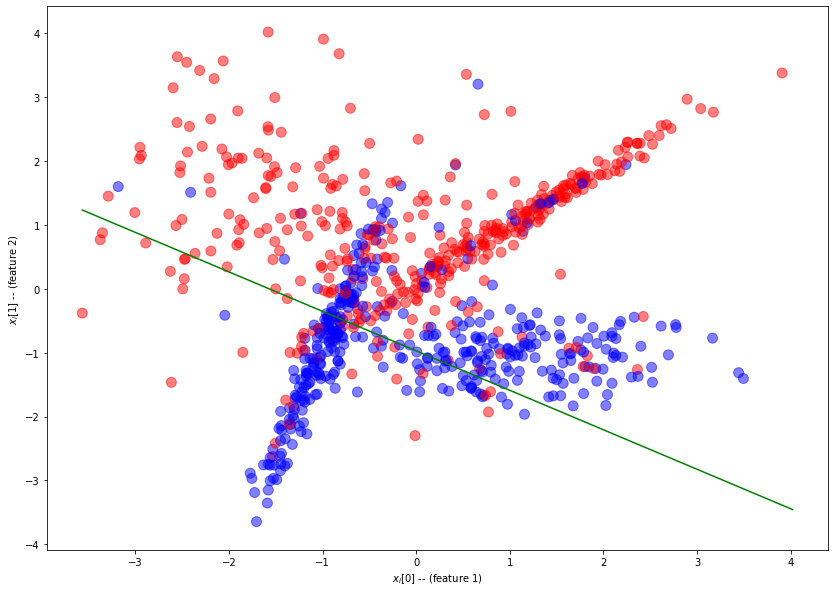

In [6]:
plot_dataset(train_x, train_labels, W.numpy(), b.numpy())

Создание тензорных датасетов

In [7]:
data_train = tf.data.Dataset.from_tensor_slices((train_x, train_labels.astype(np.float32)))
data_train = data_train.batch(16)

data_test = tf.data.Dataset.from_tensor_slices((test_x, test_labels.astype(np.float32)))
data_test = data_test.batch(16)

Вспомогательные функции

In [8]:
# функция обучения модели по пакетам данных
@tf.function
def train_on_batch(x, y, is_train=True):
  vars = [W, b]
  with tf.GradientTape() as tape:
    z = tf.sigmoid(tf.matmul(x, W) + b)
    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(z,y))
    correct_prediction = tf.equal(tf.round(y), tf.round(z))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    if is_train:
      grads = tape.gradient(loss, vars)
      optimizer.apply_gradients(zip(grads,vars))
  return loss, acc


# функция обучения модели по эпохам
def train_on_epoch(data_train, data_test, epochs: int, img_dir: str, verbose=False, draw_training_plot=True):
  train_loss = []
  train_acc = []
  test_loss = []
  test_acc = []
  for epoch in range(40):
    for step, (x, y) in enumerate(data_train):
      loss, acc = train_on_batch(tf.reshape(x, (-1, 2)), tf.reshape(y, (-1, 1)))
    train_loss.append(loss.numpy())
    train_acc.append(acc.numpy())

    for step, (x, y) in enumerate(data_test):
      loss, acc = train_on_batch(tf.reshape(x, (-1, 2)), tf.reshape(y, (-1, 1)), False)
    test_loss.append(loss.numpy())
    test_acc.append(acc.numpy())

    if verbose:
      print(f'Epoch {epoch}:\n\t last batch train loss = {train_loss[-1]:.3f}, acc = {train_acc[-1]:.2f}%\
                            \n\t last batch test loss = {test_loss[-1]:.3f}, acc = {test_acc[-1]:.2f}%')

  if draw_training_plot:
    plot_acc_loss(train_acc, test_acc, train_loss, test_loss, img_dir)

  

# функция вывода графиков точности и ошибок на этапе обучения модели
def plot_acc_loss(train_acc, test_acc, train_loss, test_loss, img_dir=None):
  x = range(len(train_loss))

  plt.figure(figsize=(16, 16))
  plt.subplot(2, 2, 1)
  plt.plot(x, train_acc, label='Train Accurancy')
  plt.plot(x, test_acc, label='Test Accurancy')
  plt.xlabel('Epochs')
  plt.ylabel('Accurancy')
  plt.legend(loc='lower right')
  plt.ylim((0, 1))
  plt.grid(True, linestyle='--')
  plt.title('Training and Validation Accurancy')

  plt.subplot(2, 2, 2)
  plt.plot(x, train_loss, label='Train Loss')
  plt.plot(x, test_loss, label='Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='center right')
  plt.grid(True, linestyle='--')
  plt.title('Training and Validation Loss')

  print(f'Final Train Accurancy: {(train_acc[-1]*100):.2f}%')
  print(f'Final Test Accurancy: {(test_acc[-1]*100):.2f}%')
  print(f'Final Train Loss: {train_loss[-1]:.3f}')
  print(f'Final Test Loss: {test_acc[-1]:.3f}')

  if img_dir is not None:
    if not os.path.isdir(img_dir):
      os.mkdir(img_dir)

    img_name = f'Trainig and Validation (Accurancy, Loss).png'
    plt.savefig(os.path.join(img_dir, img_name), bbox_inches='tight')
  plt.show()

Создание оптимизатора `Adam()` и переопределение весов

In [9]:
optimizer = tf.keras.optimizers.Adam(0.1)
W = tf.Variable(tf.random.normal(shape=(2, 1)))
b = tf.Variable(tf.zeros(shape=(1,) ,dtype=tf.float32))

Обучение модели по эпохам, вывод графиков, сохранение грофика в виде изображения

Final Train Accurancy: 81.25%
Final Test Accurancy: 62.50%
Final Train Loss: 2.881
Final Test Loss: 0.625


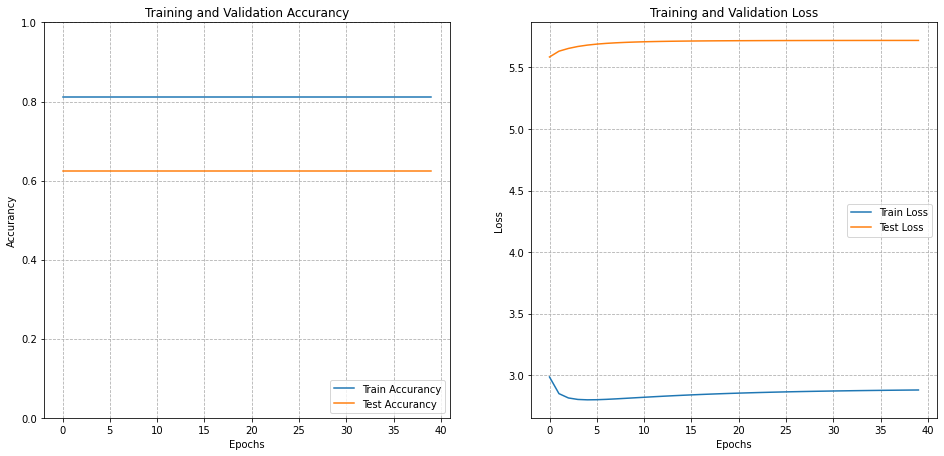

In [10]:
train_on_epoch(data_train, data_test, 40, img_dir='graphics')

In [11]:
# архивирование папки с графиками
!zip -r /content/graphics.zip /content/graphics

  adding: content/graphics/ (stored 0%)
  adding: content/graphics/Trainig and Validation (Accurancy, Loss).png (deflated 28%)


In [12]:
# скачивание архива себе на ПК
from google.colab import files
files.download("/content/graphics.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Задание 2. 

Попробуйте решить задачу классификации на датасете MNIST с помощью этого кода. Подсказка: используйте softmax_crossentropy_with_logits или sparse_softmax_cross_entropy_with_logits в качестве функции ошибки. При этом в первом случае на выход сети необходимо подавать целевые значения в формате one hot encoding, а во втором - в виде целочисленного номера класса.

In [ ]:
!pip install gzip-reader
!pip install rm
!pip install wget

In [ ]:
img_dir = os.path.join(os.getcwd(), 'img_mnist')
if os.path.isdir(img_dir):
    shutil.rmtree(img_dir)

In [ ]:
data_dir = os.path.join(os.getcwd(), '/content/data/mnist')

if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

In [ ]:
!rm -r /content/data/mnist
!wget -P data/mnist https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/data/mnist/mnist.pkl.gz
!gzip -d /content/data/mnist/mnist.pkl.gz

In [ ]:
import pickle

with open(os.path.join(data_dir, 'mnist.pkl'), 'rb') as f:
    MNIST = pickle.load(f)

In [ ]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

In [ ]:
print(f'Количество признаков (пикселей): {data.shape[1]}')
print(f'Количество объектов (картинок): {data.shape[0]}')
print(f'Количество разных ответов (классов): {len(np.unique(labels))}')

Количество признаков (пикселей): 784
Количество объектов (картинок): 42000
Количество разных ответов (классов): 10


In [531]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [532]:
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

In [785]:
# функция обучения модели по пакетам данных
def train_on_batch2(x, y, is_train=True):
  vars = [W, b]
  # tf.placeholder
  # x = images = tf.image.convert_image_dtype(images, dtype=tf.float32)
  
  z = tf.reduce_mean(tf.nn.sigmoid(tf.matmul(x, W) + b))
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=z))
  correct_prediction = tf.equal(tf.round(tf.cast(y, tf.int32)), tf.round(tf.cast(z, tf.int32)))
  acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

  if is_train:
    fit_optimizer(loss, vars)
  return loss, acc


@tf.function
def fit_optimizer(loss, vars):
  with tf.GradientTape() as tape:
    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads,vars))


# функция обучения модели по эпохам
def train_on_epoch2(data_train, data_test, epochs: int, img_dir: str, verbose=False, draw_training_plot=True):
  train_loss = []
  train_acc = []
  test_loss = []
  test_acc = []
  for epoch in range(epochs):
    for step, (x, y) in enumerate(data_train):
      print(tf.reshape(y,(-1,1)).shape)
      print(tf.reshape(x,(-1,28)).shape)
      # loss, acc = train_on_batch2(tf.reshape(x,(-1,28*28)), tf.reshape(y,(-1,1)))
      loss, acc = train_on_batch2(x, y)
    train_loss.append(loss.numpy())
    train_acc.append(acc.numpy())

    for step, (x, y) in enumerate(data_test):
      # loss, acc = train_on_batch2(tf.reshape(x, (-1, 28*28)), tf.reshape(y,(-1,1)), False)
      loss, acc = train_on_batch2(x, y, False)
    test_loss.append(loss.numpy())
    test_acc.append(acc.numpy())

    if verbose:
      print(f'Epoch {epoch}:\n\t last batch train loss = {train_loss[-1]:.3f}, acc = {train_acc[-1]:.2f}%\
                            \n\t last batch test loss = {test_loss[-1]:.3f}, acc = {test_acc[-1]:.2f}%')

  if draw_training_plot:
    plot_acc_loss(train_acc, test_acc, train_loss, test_loss, img_dir)

In [786]:
data_train = tf.data.Dataset.from_tensor_slices((x_train, y_train.astype(np.int32)))
data_train = data_train.batch(28)

data_test = tf.data.Dataset.from_tensor_slices((x_test, y_test.astype(np.float32)))
data_test = data_test.batch(28)

In [787]:
optimizer = tf.keras.optimizers.Adam(0.1)
W = tf.Variable(tf.random.normal(shape=(28*28, 10)))
b = tf.Variable(tf.zeros(shape=(28, 10),dtype=tf.float32))
# W = tf.Variable(tf.zeros([28*28, 10]))
# b = tf.Variable(tf.zeros([10]))

In [ ]:
train_on_epoch2(data_train, data_test, 40, img_dir='grapics')